### We have data about users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeated usersand the number of pages wisited during that session (as a proxy for site activity/time spent on site).
### Your project is to:
#### (1) Predict conversion rate
#### (2) Come up with recommendations for the product team and the marketing team to improve conversion rate.

### Load the package would be used

In [1]:
import pandas as pd
pd.set_option("display.max_columns", 10)
pd.set_option("display.width", 350)

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({"figure.autolayout": True})
import seaborn as sns
sns.set(style = "white")
sns.set(style = "whitegrid", color_codes = True)

import numpy as np

from sklearn.metrics import confusion_matrix, auc, roc_curve, classification_report
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

### Read in the data set

In [2]:
#### Read file
dat0 = pd.read_csv("../Datasets/conversion_data.csv")
print(dat0.head())

  country  age  new_user source  total_pages_visited  converted
0      UK   25         1    Ads                    1          0
1      US   23         1    Seo                    5          0
2      US   28         1    Seo                    4          0
3   China   39         1    Seo                    5          0
4      US   30         1    Seo                    6          0


### Look into data set

#### Inspect the data to look for weird behavior/wrong data

In [3]:
print(dat0.describe())
print(dat0.groupby(["country"]).size())
print(dat0.groupby(["source"]).size())

                 age       new_user  total_pages_visited      converted
count  316200.000000  316200.000000        316200.000000  316200.000000
mean       30.569858       0.685465             4.872966       0.032258
std         8.271802       0.464331             3.341104       0.176685
min        17.000000       0.000000             1.000000       0.000000
25%        24.000000       0.000000             2.000000       0.000000
50%        30.000000       1.000000             4.000000       0.000000
75%        36.000000       1.000000             7.000000       0.000000
max       123.000000       1.000000            29.000000       1.000000
country
China       76602
Germany     13056
UK          48450
US         178092
dtype: int64
source
Ads        88740
Direct     72420
Seo       155040
dtype: int64


Everything seems to be reasonable except for the max age $123$ years old.

In [4]:
print(sorted(dat0["age"].unique(), reverse = True))

[123, 111, 79, 77, 73, 72, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17]


Those $123$ and $111$ values seem unrealistic.

In [5]:
print(dat0[dat0["age"] > 80])

        country  age  new_user source  total_pages_visited  converted
90928   Germany  123         0    Seo                   15          1
295581       UK  111         0    Ads                   10          1


It is just $2$ users. We may remove them directly.

In [6]:
dat = dat0[dat0["age"] < 110]

### Visualization

#### By country

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


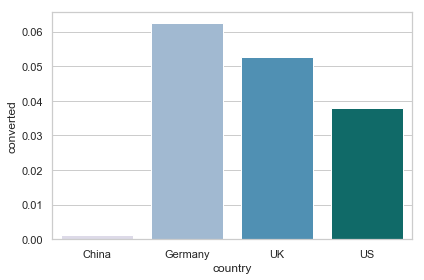

In [7]:
grp_country = dat[["country", "converted"]].groupby("country").mean().reset_index()
sns.barplot(x = "country", y = "converted", data = grp_country, palette = "PuBuGn")

It Looks like Chinese convert at a much lower rate than other countries.

#### By marketing channels

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


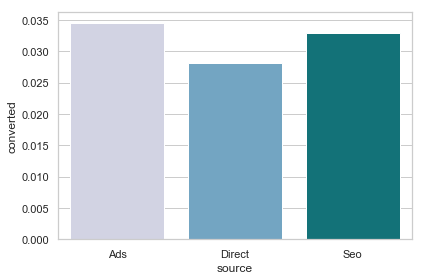

In [8]:
grp_source = dat[["source", "converted"]].groupby("source").mean().reset_index()
sns.barplot(x = "source", y = "converted", data = grp_source, palette = "PuBuGn")

#### By if new users

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


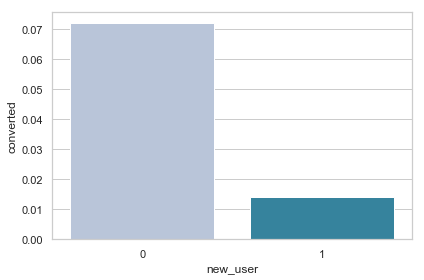

In [9]:
grp_newuser = dat[["new_user", "converted"]].groupby("new_user").mean().reset_index()
sns.barplot(x = "new_user", y = "converted", data = grp_newuser, palette = "PuBuGn")

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


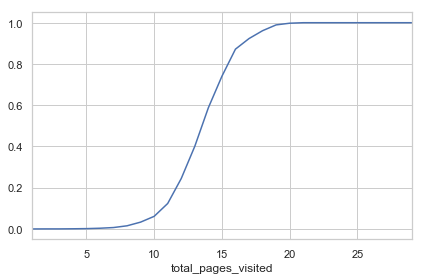

In [10]:
dat.groupby(["total_pages_visited"])["converted"].mean().plot()
plt.show()

#### By total pages visited

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


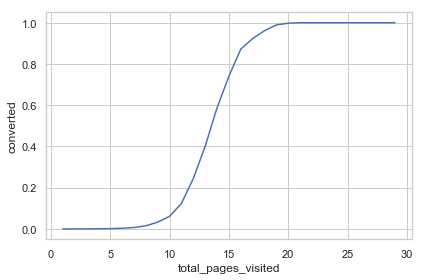

In [11]:
grp_page = dat[["total_pages_visited", "converted"]].groupby("total_pages_visited").mean().reset_index()
sns.lineplot(x = "total_pages_visited", y = "converted", data = grp_page, palette = "PuBuGn")

#### By age

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


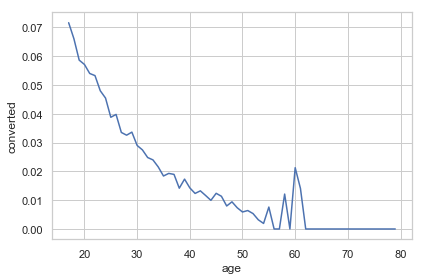

In [12]:
grp_age = dat[["age", "converted"]].groupby("age").mean().reset_index()
sns.lineplot(x = "age", y = "converted", data = grp_age, palette = "PuBuGn")

### Machine Learning Model

In [13]:
#### Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,39 mins 46 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.1
H2O cluster version age:,44 minutes
H2O cluster name:,H2O_from_python_veronica_ojsale
H2O cluster total nodes:,1
H2O cluster free memory:,3.881 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


#### Convert the data set to the h2o frame and convert all categorical variables to factors

In [14]:
dat_h2o = H2OFrame(dat)
dat_h2o["converted"] = dat_h2o["converted"].asfactor()
dat_h2o["country"] = dat_h2o["country"].asfactor()
dat_h2o["source"] = dat_h2o["source"].asfactor()
dat_h2o["new_user"] = dat_h2o["new_user"].asfactor()
dat_h2o.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,country,age,new_user,source,total_pages_visited,converted
type,enum,int,enum,enum,int,enum
mins,,17.0,,,1.0,
mean,,30.56931100133461,,,4.872918234777001,
maxs,,79.0,,,29.0,
sigma,,8.268957596421435,,,3.3410533442156285,
zeros,,0,,,0,
missing,0,0,0,0,0,0
0,UK,25.0,1,Ads,1.0,0
1,US,23.0,1,Seo,5.0,0
2,US,28.0,1,Seo,4.0,0


#### Split data set to the training set and testing set

In [15]:
index = dat_h2o["converted"].stratified_split(test_frac = 0.34, seed = 2019)
train_dat = dat_h2o[index == "train"]
test_dat = dat_h2o[index == "test"]
X0 = ["country", "source", "new_user", "age", "total_pages_visited"]
Y = "converted"

#### Build a random forest model

In [16]:
RF0 = H2ORandomForestEstimator(balance_classes = False, ntrees = 100, max_depth = 20, 
                               mtries = -1, seed = 2019, score_each_iteration = True)
RF0.train(x = X0, y = Y, training_frame = train_dat)

drf Model Build progress: |███████████████████████████████████████████████| 100%


#### Examine if overfitting (though it's unlikely for a random forest)

In [17]:
train_true = train_dat.as_data_frame()["converted"].values
test_true = test_dat.as_data_frame()["converted"].values
train_pred = RF0.predict(train_dat).as_data_frame()["predict"].values
test_pred = RF0.predict(test_dat).as_data_frame()["predict"].values

train_confusion = confusion_matrix(train_true, train_pred)
print (train_confusion/train_confusion.astype(np.float).sum(axis = 1))

test_confusion = confusion_matrix(test_true, test_pred)
print (test_confusion/test_confusion.astype(np.float).sum(axis = 1))

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
[[0.99641513 0.10756203]
 [0.00828877 0.75129996]]
[[0.99455978 0.16325353]
 [0.01035179 0.68935679]]


In [18]:
train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)
print(classification_report(y_true=test_true, y_pred = (test_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    104040
           1       0.81      0.69      0.74      3467

   micro avg       0.98      0.98      0.98    107507
   macro avg       0.90      0.84      0.87    107507
weighted avg       0.98      0.98      0.98    107507



#### Variable importance

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


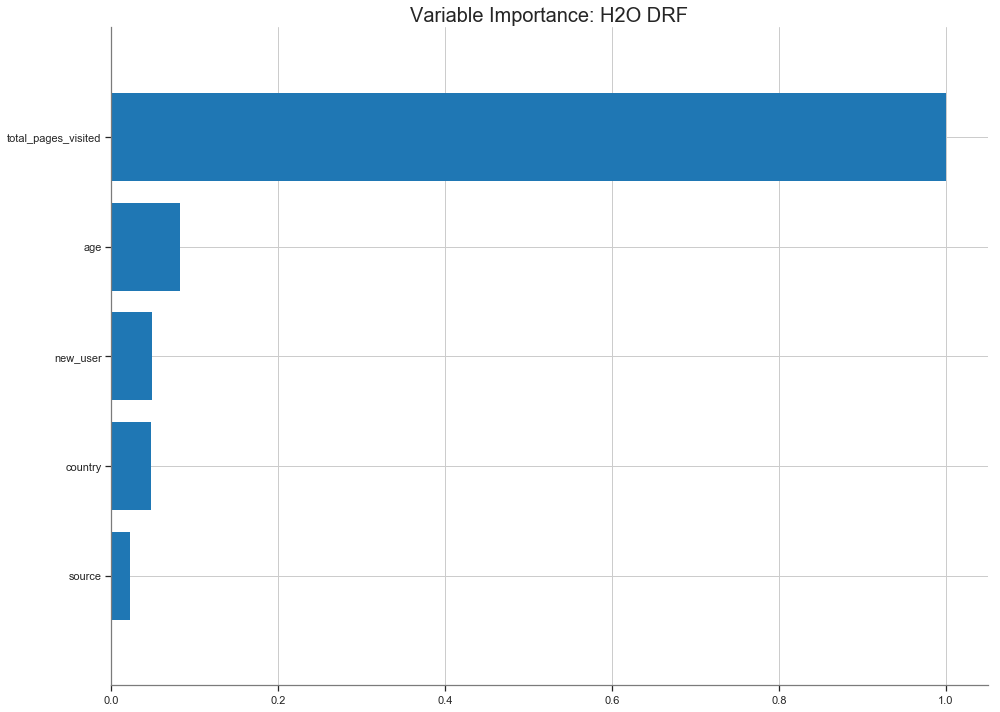

In [19]:
RF0.varimp_plot()

From the above plot, the most important feature is the total page visits, which makes sense. Generally, users who reviewed more pages have higher willingness to pay for the product/service. But it's not very useful since we basically can do nothing for that feature. Let's remove the feature and redo the random forest.

#### Remove the total_pages_visited variable and redo the analysis

In [20]:
X = ["country", "source", "new_user", "age"]
Y = "converted"
RF = H2ORandomForestEstimator(balance_classes = False, ntrees = 100, max_depth = 20, 
                              mtries = -1, seed = 2019, score_each_iteration = True)
RF.train(x = X, y = Y, training_frame = train_dat)
train_true = train_dat.as_data_frame()["converted"].values
test_true = test_dat.as_data_frame()["converted"].values
train_pred = RF.predict(train_dat).as_data_frame()["predict"].values
test_pred = RF.predict(test_dat).as_data_frame()["predict"].values

train_confusion = confusion_matrix(train_true, train_pred)
print (train_confusion/train_confusion.astype(np.float).sum(axis = 1))

test_confusion = confusion_matrix(test_true, test_pred)
print (test_confusion/test_confusion.astype(np.float).sum(axis = 1))

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)
print (classification_report(y_true=test_true, y_pred = (test_pred > 0.5).astype(int)))

drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
[[0.91319568 2.60451642]
 [0.01850366 0.44480761]]
[[0.91103422 2.66974329]
 [0.01921376 0.42342082]]
              precision    recall  f1-score   support

           0       0.98      0.91      0.94    104040
           1       0.14      0.42      0.21      3467

   micro avg       0.90      0.90      0.90    107507
   macro avg       0.56      0.67      0.58    107507
weighted avg       0.95      0.90      0.92    107507



/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


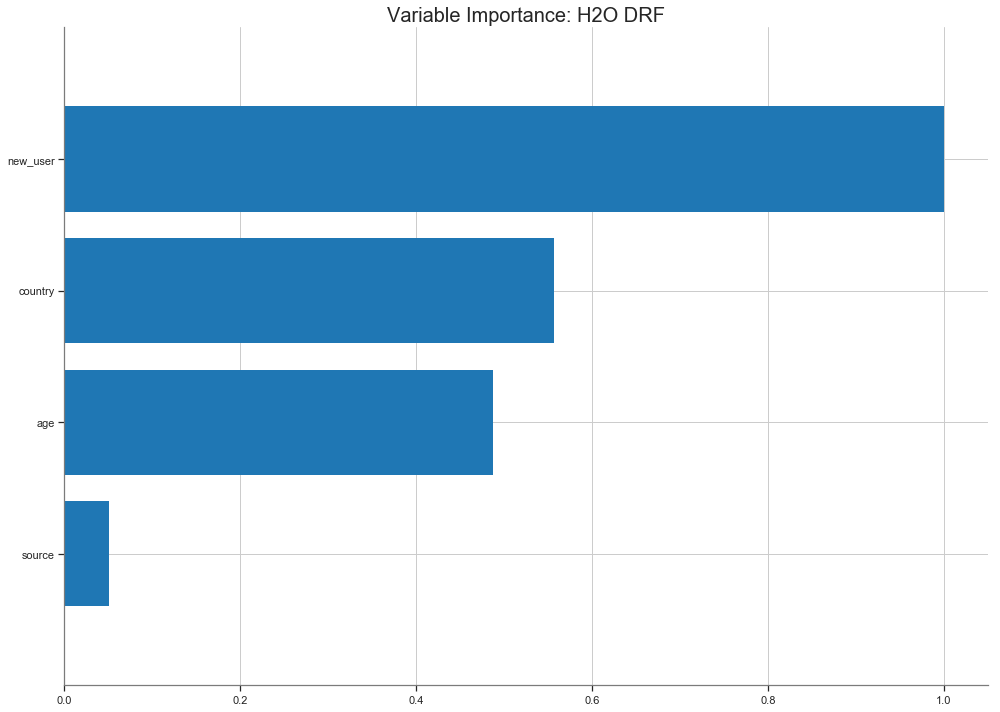

In [21]:
RF.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%
PartialDependence: Partial Dependence Plot of model DRF_model_python_1563242708389_607 on column 'new_user'



new_user,mean_response,stddev_response,std_error_mean_response
0,0.0707956,0.0558543,0.0001223
1,0.0140058,0.0111670,0.0000244


PartialDependence: Partial Dependence Plot of model DRF_model_python_1563242708389_607 on column 'country'



country,mean_response,stddev_response,std_error_mean_response
China,0.0019011,0.0019031,0.0000042
Germany,0.0605202,0.0695444,0.0001522
UK,0.0512989,0.0534191,0.0001169
US,0.0374420,0.0379603,0.0000831


PartialDependence: Partial Dependence Plot of model DRF_model_python_1563242708389_607 on column 'age'



age,mean_response,stddev_response,std_error_mean_response
17.0,0.0621456,0.0693831,0.0001519
20.2631579,0.0515195,0.0601739,0.0001317
23.5263158,0.0448680,0.0509761,0.0001116
26.7894737,0.0324544,0.0361288,0.0000791
30.0526316,0.0293999,0.0315953,0.0000692
33.3157895,0.0250740,0.0286573,0.0000627
36.5789474,0.0206491,0.0221456,0.0000485
39.8421053,0.0175417,0.0205225,0.0000449
43.1052632,0.0143884,0.0131076,0.0000287
46.3684211,0.0159066,0.0177444,0.0000388


PartialDependence: Partial Dependence Plot of model DRF_model_python_1563242708389_607 on column 'source'



source,mean_response,stddev_response,std_error_mean_response
Ads,0.0348075,0.0462891,0.0001013
Direct,0.0288015,0.0373920,0.0000819
Seo,0.0324170,0.0427111,0.0000935


[, , , ]

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


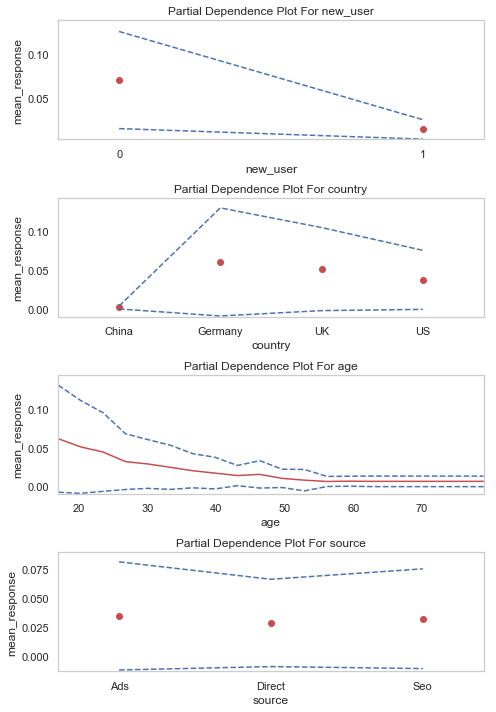

In [22]:
RF.partial_plot(data = train_dat, cols = ["new_user", "country", "age", "source"], plot = True)

In terms of model performance, the new model is worse than the previous one, but from the new model, we can get valuable insight: the conversion rate among returned users was pretty high.

The project is asking for insights in terms of how to improve the conversion rate, so the model performance is less important (the accuracy of the refitted model was even worse than a random guess, though we never evaluate a classifier using the accuracy in the data with an unbalanced outcome variable).

For how to compare classifier and decide a cut-off, please see my solution using R.